In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sintgr

## Project Schrödinger

### 1. Analytical Test: Particle in a 1-D Box 

In [282]:
#discretizing the solution space (x,Ψ(x))
#--
L = 1.0                     #length of the box: L = 1
N = 5000                    #number of points on the grid
step = L/N                  #grid spacing
x = np.linspace(0,L,N)      #discretized x-axis

In [283]:
#defining the constants
#--
h = 6.62607015*(10**(-34))  #Planck constant in kg m² /s 
hbar = h/(2*np.pi)          #reduced Planck constant in kg m² /s 
m = 9.10938370*(10**(-31))  #mass of an electron in kg
E1 = (h**2)/(8*m*L**2)      #analytical ground-state energy for a particle in a 1-D box
V0 = 1.0                    #depth of the potential well

In [284]:
#introducing dimensionless quantities
#--
gamma2 = 2000

In [306]:
#define the potential
#--
def box_potential(x):
    return np.where(np.logical_and(x > 0.0, x < 1.0), V0, 1e10) 

In [307]:
#implement the numerov algorithm
#--
def numerov (psi, g) :
    a = 2*psi[i]*(1-5*((step**2)/12)*g[i])
    b = psi[i-1]*(1+((step**2)/12)*g[i-1])
    c = 1 + ((step**2)/12)*g[i+1]
    return (a-b)/c

In [308]:
#implement the function that finds the wave function
#--
def find_psi(epsilon) :
    
    #create an array containing g(x_i)
    g = np.zeros(N)
    for i in range(0,N):
        g[i] = gamma2*(epsilon-box_potential(x[i]))
    
    #define a array of zeros to contain the values of the wavefunction
    psi = np.zeros(N)
    #append the boundary condition on the left
    psi[0] = 0.0
    #append the guessed value for the second point on the grid
    psi[1] = step
    
    #propagate the solution with numerov
    for i in range(0,N-2):
        psi[i+2] = ((2*psi[i+1]*(1-5*((step**2)/12)*g[i+1])) - (psi[i]*(1+((step**2)/12)*g[i])))/(1 + ((step**2)/12)*g[i+2])

    #return an array containing the values of the wavefunction for each point on the grid
    return psi

In [340]:
#find the first wave function by randomly guessing epsilon until Ψ(x = L) is close to zero
#--
epsilon = 1.0197471068538702
psi = find_psi(epsilon)
psi[-1]

9.845825428277079e-16

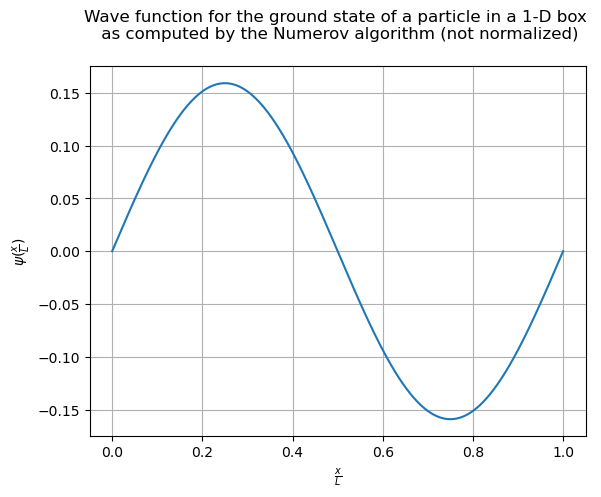

In [341]:
#plot the wave fuction computed by the Numerov algorithm to verify the shape
#--
plt.plot(x,psi)
plt.xlabel(r'$\frac{x}{L}$')
plt.ylabel(r'$\psi(\frac{x}{L})$')
plt.title("Wave function for the ground state of a particle in a 1-D box \n as computed by the Numerov algorithm (not normalized)", pad=20)
plt.grid()
plt.show()

In [311]:
#define a function to compute the integral
#--
def newton_cotes(Nr, N, y, dx) :
    
    #recover the weights and the error associated with the order of interpolation
    #--
    w, e = sintgr.newton_cotes(Nr)
    
    #define a variable that will contain the sum over the integral
    #--
    s = 0.
    
    #calculate the integral
    #--
    for i in range(0, N-Nr, Nr):
        s += w.dot((y[i:i+Nr+1]))
        
    #return the result
    #--
    result = s*dx
    return result, e

In [312]:
#define a function that normalizes the wave function
#--
def normalize(psi) : 
    
    #find the normalization constant
    psi2 = psi**2
    integral, error = newton_cotes(2, N, psi2, step)
    C = 1/integral
    
    #normalize the wave function
    psi *= np.sqrt(C)
    
    #return the normalized wave function
    return psi

In [313]:
#normalize the wave function
#--
normalized_psi = normalize(psi)

In [314]:
#verify normalization
#--
integral, error = newton_cotes(2, N, normalized_psi**2, step)
print(integral)

1.0000000000000004


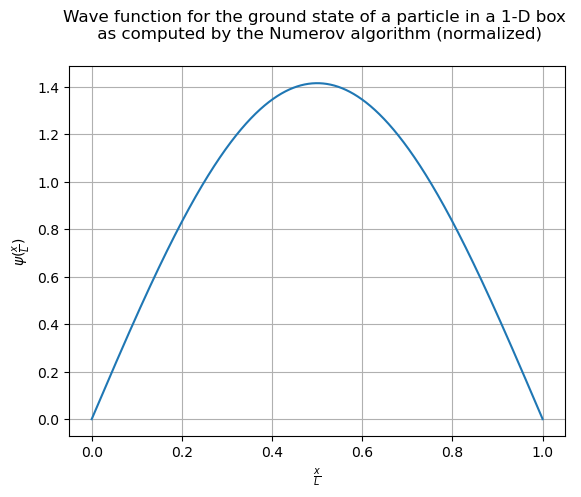

In [315]:
#plot the normalized solution as computed by the Numerov algorithm
#--
plt.plot(x,normalized_psi)
plt.xlabel(r'$\frac{x}{L}$')
plt.ylabel(r'$\psi(\frac{x}{L})$')
plt.title("Wave function for the ground state of a particle in a 1-D box \n as computed by the Numerov algorithm (normalized)", pad=20)
plt.grid()
plt.show()

In [316]:
#define a function that computes the numerical value of the analytical solutions for the problem
#--
def analytical_solution(x,n,L,C):
    return C*np.sin(n*np.pi*x/L)

In [317]:
#compute the analytical solution for the ground state
#--
n = 1.0
C = np.sqrt(2)
analytical_psi = analytical_solution(x,n,L,C)

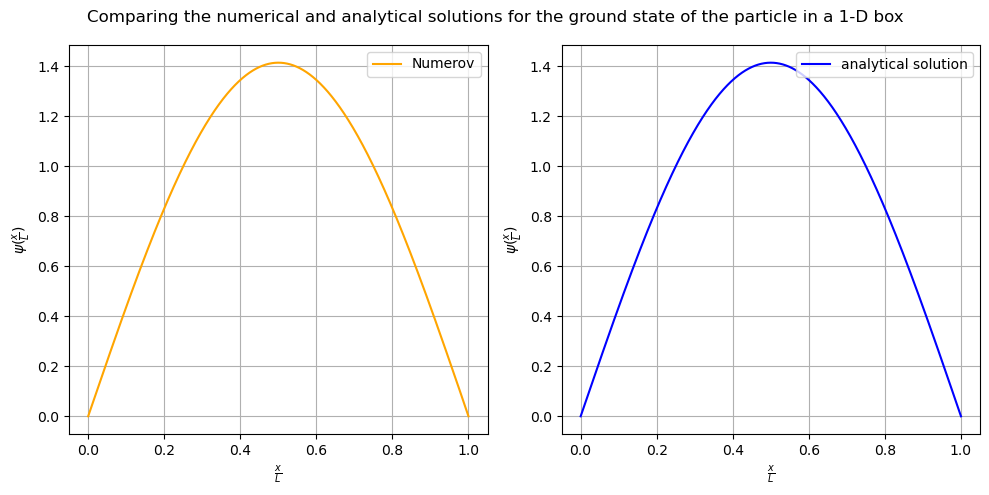

In [318]:
#compare the analytical solution and the Numerov solution
#--
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Comparing the numerical and analytical solutions for the ground state of the particle in a 1-D box")

ax1.plot(x,psi, color="orange", label="Numerov")
ax2.plot(x,analytical_psi, color="blue", label="analytical solution")
ax1.set_xlabel(r'$\frac{x}{L}$')
ax1.set_ylabel(r'$\psi(\frac{x}{L})$')
ax2.set_xlabel(r'$\frac{x}{L}$')
ax2.set_ylabel(r'$\psi(\frac{x}{L})$')
ax1.grid()
ax2.grid()
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [332]:
#define a fonction that finds the allowed energy levels by using the overshooting method
#--
def find_energy(epsilon, d_epsilon):

    psi1 = find_psi(epsilon)
    epsilon = epsilon+d_epsilon
    
    #the loops runs until the desired precision is attained 
    while(abs(d_epsilon) > 1e-12):
        
        psi2 = find_psi(epsilon)
   
        #this condition ensures that we have found an over/undershoot, i.e. that the sign of psi[-1] changes when ε becomes ε+dε
        if (psi1[-1]*psi2[-1] < 0): 
            d_epsilon = -d_epsilon/2

        epsilon = epsilon+d_epsilon
        psi1 = psi2
    return epsilon

In [338]:
#find the five first energy levels and wavefunctions
#--
eigenvalues = []
eigenfunctions = []

energy = find_energy(1.001, 0.001) #start looking for energies just a little above V0 = 1.0
psi = find_psi(energy)
eigenvalues.append(energy)
eigenfunctions.append(psi)

for i in range(4) :
    energy = find_energy(energy+0.001, 0.001)
    psi = find_psi(energy)
    eigenvalues.append(energy)
    eigenfunctions.append(psi)

In [339]:
eigenvalues

[1.0049367767116046,
 1.0197471068538702,
 1.0444309904249331,
 1.0789884274173438,
 1.1234194178404149]

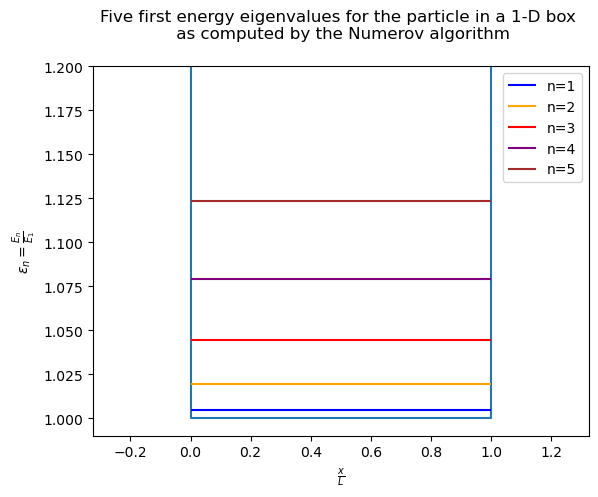

In [346]:
#plot the five first energy eigenvalues
#--

#define a new x-axis
new_x = np.linspace(-0.25, 1.25, 1000)

#draw the box
plt.plot(new_x, box_potential(new_x))

#create a list of colors
color_list = ['blue', 'orange', 'red', 'purple', 'brown']

#draw the energies
for i in range(5):
    plt.hlines(eigenvalues[i], 0.0, 1.0, color=color_list[i], label=f"n={i+1}")

#set the graph options
plt.ylim(0.99, 1.20)
plt.xlabel(r'$\frac{x}{L}$')
plt.ylabel(r'$\epsilon_n = \frac{E_n}{E_1}$')
plt.legend()
plt.title("Five first energy eigenvalues for the particle in a 1-D box \n as computed by the Numerov algorithm", pad=20)
plt.show()

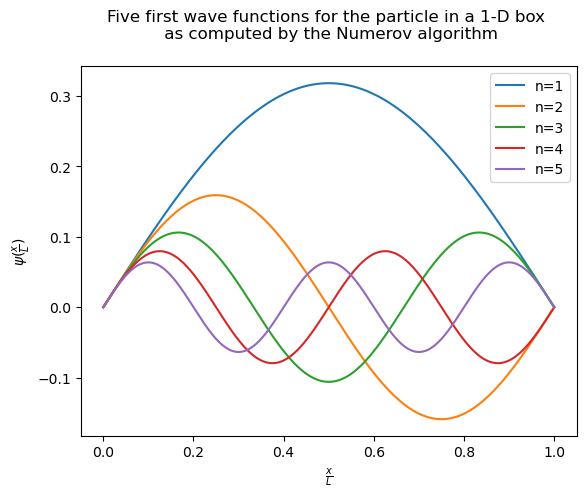

In [347]:
#plot the five first eigenfunctions
#--
for i in range(5):
    plt.plot(x, eigenfunctions[i], label=f"n={i+1}")

#set the graph options
plt.xlabel(r'$\frac{x}{L}$')
plt.ylabel(r'$\psi(\frac{x}{L})$')
plt.legend()
plt.title("Five first wave functions for the particle in a 1-D box \n as computed by the Numerov algorithm", pad=20)
plt.show()